# Supervised Learning

Very simply put supervised learning is the process of fitting any given function to a set of labelled data. In the sections that follow we will walk through some of the more common supervised learning algorithms that are likely to encounter on the path to machine mastery. This notebook will try to use the [scikit-learn](http://scikit-learn.org/stable/ "scikit-learn homepage") library to implement each of these algorithms with ease and simplicity. The algorithms we will be looking at are:
- [k-Nearest Neighbours](#knn)
- [Naive Bayes](#naive_bayes)
- [Linear Regression](#linear_regression)
- [Logistic Regression](#logistic_regression)
- [Decision Trees](#decision_trees)
- [Support Vector Machines](#svm)

Here is a great overview of the different classification techniques in `scikit-learn`.
![sklearn classifier overview](http://scikit-learn.org/stable/_static/ml_map.png)

In [2]:
# Import the necessary libraries
import urllib
from sklearn import datasets, model_selection, neighbors, linear_model, tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In [3]:
# This is a handy plotting function
from matplotlib.colors import ListedColormap

def visualise_decision_surface(X, y, clf):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    x_min -= 0.1*np.abs(x_min)
    x_max += 0.1*np.abs(x_max)
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    y_min -= 0.1*np.abs(y_min)
    y_max += 0.1*np.abs(y_max)
    hx = (x_max - x_min) / 1000
    hy = (y_max - y_min) / 1000
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx),
                         np.arange(y_min, y_max, hy))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    if type(Z[0][0]) == str:
        y = (y == Z[0][0])
        Z = (Z == Z[0][0])

    my_cmap = ListedColormap(sns.color_palette("deep").as_hex())
    plt.contourf(xx, yy, Z, alpha=0.6, cmap=my_cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
#     plt.show()

## k-Nearest Neighbours <a id='knn'></a>

k-Nearest Neighbours, or kNN, is one of the simplest supervised machine learning algorithms. It is non-parametric and instance based, meaning that it does not try to fit a global model to your data it merely remembers the instances it has been shown. First introduced in [1970](http://www.dtic.mil/dtic/tr/fulltext/u2/a800276.pdf "Discriminatory analysis, nonparametric discrimination: Consistency properties") the principle behind kNN is very simple; find $k$ points in the existing dataset that are "closest" to the point you wish to analyse, make a prediction based off their values.

Some common metrics include:

__Euclidean:__
$$D_{\textrm{Euclidean}}(x,x') = \sqrt{\sum_{i=1}^k \left(x_i - x'_i\right)^2} $$

__Manhattan:__
$$D_{\textrm{Manhattan}}(x,x') = \sum_{i=1}^k \left|x_i - x'_i\right| $$

__Minkowski:__
$$D_{\textrm{Minkowski}}(x,x') = \left(\sum_{i=1}^k \left(\left|x_i - x'_i\right|\right)^q\right)^{1/q} $$

__Chebyshev:__
$$D_{\textrm{Chebyshev}}(x,x') = \max_i\left(\left|x_i - x'_i\right|\right)$$

__Hamming:__ (for categorical data)
$$D_{\textrm{Hamming}}(x,x') = \sum_{i=1}^k \left|x_i - x'_i\right|, \textrm{ where } D(x,x') = 0 \textrm{ if } x=x' \textrm{ and } D(x,x') = 1 \textrm{ if } x\ne x' $$

Note that the Euclidean distance, $D_{\textrm{Euclidean}}$, is simply the Minkowski distance, $D_{\textrm{Minkowski}}$, with $q=2$. This is actually the default for the `KNeighborsClassifier` from `scikit-learn` that we are usin below.

You could make your prediction in two ways, depending on your problem: either regression or classification. For example, given a dataset containing information on housing prices you could try to estimate the value of a property using *regression* (say by taking the average of your neighbours) or you could try to *classify* the property as, "buy," "sell" or "hold" (by choosing the majority class in your neighbourhood).

### kNN Classification 

Let's jump straight into it! Scikit-learn has a whole bunch of different [nearest neighbour](http://scikit-learn.org/stable/modules/neighbors.html "sklearn nearest neighbour techniques") implementations built in. Lets just play with some toy data for now

In [99]:
VAR1 = (12, 12)
print(VAR1)
a, b = VAR1
print(a)
print(b)

(12, 12)
12
12


In [4]:
X, y = datasets.make_classification(n_samples=1000, n_features=2, n_redundant=0)
print(X.shape)
print(y.shape)
# Split into test / train sets and label / feature vectors
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

(1000, 2)
(1000,)


In [5]:
#print(X)
#print(y)

In [7]:
# Create classifier
knn_classifier = neighbors.KNeighborsClassifier(200)
knn_classifier.fit(X_train, 
                   y_train)

# Classify test set
knn_classifier.score(X_test,
                     y_test)

0.928

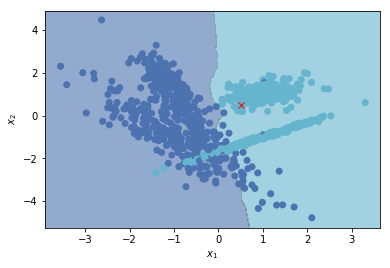

In [8]:
visualise_decision_surface(X, y, knn_classifier)
plt.plot([0.5], [0.5], "rx")
plt.show()

We are going to grab the [breast cancer Wisconsin](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29 "UCI repository breast cancer dataset") from the [UCI ML repo](https://archive.ics.uci.edu/ml/index.php "UCI machine learning repository") and see if we can't classify some suspicious tumours as either "benign" or "malignant." If you are interested in the dataset you can check out the [schema](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names "breast cancer Wisconsin dataset schema"). This dataset should be a little more challenging as we now have an input vector of length 30.

In [9]:
# Download the dataset and load it into pandas dataframe
bcwd_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
feature_names = ["ID number", "diagnosis",
                 "radius - mean", "texture - mean", "perimeter - mean", "area - mean", "smoothness - mean", "compactness - mean", "concavity - mean", "concave points - mean", "symmetry - mean", "fractal dimension - mean",
                 "radius - std err", "texture - std err", "perimeter - std err", "area - std err", "smoothness - std err", "compactness - std err", "concavity - std err", "concave points - std err", "symmetry - std err", "fractal dimension - std err",
                 "radius - largest", "texture - largest", "perimeter - largest", "area - largest", "smoothness - largest", "compactness - largest", "concavity - largest", "concave points - largest", "symmetry - largest", "fractal dimension - largest"
                ]
mcwd_df = pd.read_csv(bcwd_url,
                      delimiter=",",
                      header=None,
                      names=feature_names,    # Strings for our column headings
                      index_col=0,
                     )

In [11]:
# Split into test / train sets and label / feature vectors
train_df, test_df = model_selection.train_test_split(mcwd_df)

X_train = train_df.iloc[:,-30:].values
y_train = train_df["diagnosis"].values

X_test = test_df.iloc[:,-30:].values
y_test = test_df["diagnosis"].values

X_vis = X_train[:, [0,4]]
y_vis = y_train

In [12]:
# Create classifier
knn_classifier = neighbors.KNeighborsClassifier(200)
knn_classifier.fit(X_train, 
                   y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=200, p=2,
           weights='uniform')

In [13]:
# Classify test set
knn_classifier.score(X_test,
                     y_test)

0.9230769230769231

In [17]:
# import seaborn as sns
from matplotlib import pyplot as plt
MIN_DATA_URL = "http://www.bom.gov.au/climate/change/acorn/sat/data/acorn.sat.minT.087031.daily.txt"
MAX_DATA_URL = "http://www.bom.gov.au/climate/change/acorn/sat/data/acorn.sat.maxT.087031.daily.txt"

import requests

min_string_data = requests.get(MIN_DATA_URL).text
max_string_data = requests.get(MAX_DATA_URL).text

print(type(min_string_data))
#print(min_string_data)



<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'numpy.float64'>


In [18]:
from io import StringIO
import pandas as pd

# Make data appear file-like
min_data = StringIO(min_string_data)
max_data = StringIO(max_string_data)

# Import data into a Pandas dataframe
min_df = pd.read_csv(min_data,
                     delim_whitespace=True,       # Let Pandas know that white space is our delimiter
                     names=["date", "min_temp"],  # Strings for our column headings
                     skiprows=1,                  # Skip the header row
                     parse_dates=[0])             # Parse the first column as a date type
max_df = pd.read_csv(max_data,
                     delim_whitespace=True,
                     names=["date", "max_temp"],
                     skiprows=1,
                     parse_dates=[0])

print(type(min_df['date'][0]))
print(type(min_df['min_temp'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'numpy.float64'>


In [20]:
 #Select rows where the temperature is not equal to 99999.9
min_removed_df = min_df.query('min_temp != 99999.9')
max_removed_df = max_df.query('max_temp != 99999.9')
print(min_df.size)
print(min_removed_df.size)
#print(min_removed_df)

54240
53406


In [24]:
import numpy as np

# Replace the missing values with Numpy NaNs
min_nan_df = min_df.replace(to_replace=99999.9,
                            value=np.nan)
max_nan_df = max_df.replace(to_replace=99999.9,
                            value=np.nan)

#print(min_nan_df)

In [27]:
min_temp_min = max_nan_df['min_temp'].min()
min_temp_mean = max_nan_df['min_temp'].mean()
min_temp_max = max_nan_df['max_nan_df'].max()
min_temp_std = max_nan_df['max_nan_df'].std()

print("The statistical properties for our minimum temperature time series are:")
print("    - min  = {: 4.2f}".format(min_temp_min))
print("    - mean = {: 4.2f}".format(min_temp_mean))
print("    - max  = {: 4.2f}".format(min_temp_max))
print("    - std  = {: 4.2f}".format(min_temp_std))

KeyError: 'min_temp'

In [29]:
import numpy as np

# Replace the missing values with Numpy NaNs
min_nan_df = min_df.replace(to_replace=99999.9,
                            value=np.nan)
max_nan_df = max_df.replace(to_replace=99999.9,
                            value=np.nan)

#print(min_nan_df)

**Challenge -** You could try changing the number of nearest neighbours, $k$ and see how that affects the result. Try to optimse $k$. You can also try to play with the distance metric.

### kNN Regression 

This time we will use the [Beijing PM$_{2.5}$](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data "UCI repository Beijing PM2.5 dataset") from the [UCI ML repo](https://archive.ics.uci.edu/ml/index.php "UCI machine learning repository") to see wether we can do some regression using a kNN algorithm. We will see if we can predict the [PM$_{2.5}$](http://www.epa.vic.gov.au/your-environment/air/air-pollution/pm25-particles-in-air "EPA description of PM2.5") concentration in Beijing given the local weather conditions.

In [30]:
# Download the dataset and load it into pandas dataframe
pm25_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"
pm25_df = pd.read_csv(pm25_url,
                      delimiter=",",
                      header=0,
                      index_col=0,
                     )
pm25_df = pm25_df.dropna()

In [31]:
pm25_df["cbwd"].unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [32]:
# Handle categorical data
labeler = LabelEncoder()
pm25_df["cbwd"] = labeler.fit_transform(pm25_df["cbwd"])

In [33]:
pm25_df["cbwd"].unique()

array([2, 3, 1, 0], dtype=int64)

In [34]:
# Split into test / train sets and label / feature vectors
train_df, test_df = model_selection.train_test_split(pm25_df)

X_train = train_df.iloc[:,-7:].values
y_train = train_df["pm2.5"].values

X_test = test_df.iloc[:,-7:].values
y_test = test_df["pm2.5"].values

In [35]:
# Create classifier
knn_regression = neighbors.KNeighborsRegressor(n_neighbors=25)
knn_regression.fit(X_train, 
                   y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=25, p=2,
          weights='uniform')

In [37]:
y_test.max()

994.0

In [36]:
# Classify test set
knn_regression.score(X_test,
                     y_test)

0.3854629411939918

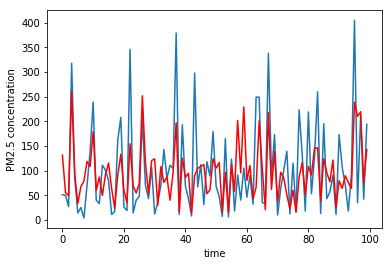

In [147]:
knn_predictions = knn_regression.predict(X_test)
plt.plot(y_test[:100])
plt.plot(knn_predictions[:100],'r')
plt.xlabel("time")
plt.ylabel("PM2.5 concentration")
plt.show()

Well I guess *sometimes* these things don't work out. Can you think why this technique is not particularly well suited to the problem at hand? Can you think of something we could do to improve the result?

**Challenge -** The nearest neighbour algorithms have many parameters to tune. Check out the [documentation]() and play with parameters to see if you can improve the result.

## Linear Regression <a id='linear_regression'></a>

Okay, we are going to cheat a little bit a create some "random" data to fit a linear line to.

In [47]:
# Create some linear data with a little bit of random noise
FEATURE_DIM = 100
NUM_SAMPLES = 100000

X = 2 * np.random.rand(NUM_SAMPLES, FEATURE_DIM)
y = 4 + np.sum(3 * X + np.random.rand(NUM_SAMPLES, FEATURE_DIM) * np.sin(X), 1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

Linear regression is simply the act of fitting a straight line to some given data, $\hat{y}$, such that the line optimises some performance metric. Typically we denote the parameterisation of this line with the vector $\theta$ such that 

$$ \hat y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n$$

where $\theta_0$ is a bias term.

Linear regression can be expressed in vector form as 

$$ \hat y = h_{\theta}(\bf{x}) = \theta^T \cdot \bf{x}$$

- $\theta$ is the model's parameter vector, containing the bias term $\theta_0$ and the feature weights $\theta_1$ to $\theta_n$
- $\bf{x}$ is the feature vector (with $x_0 = 1$)
- $h_\theta$ is the hypothesis function.

There are two ways to perform linear regression. You can either solve it exactly using some matrix gymnastics. Or more specifically using the Normal Equation you can find the set of parameters that minimises the Mean Square Error (MSE), $\hat{\theta}$:

$$\hat{\theta} = \left(\bf{X}^{T}\dot\bf{X}\right)^{-1} \dot \bf{X}^{T} \dot \bf{y}$$

where
- $\bf{y}$ is the vector containin the target values, $y^{(i)}$
- $\bf{X}$ is the vector containing the given data points, ${\bf x}^{(i)}$

The function in `scikit-learn` to do this is the `LinearRegression` function.

In [48]:
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X_train,
                      y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
linear_regression.score(X_test,
                        y_test)

0.9851772748778456

In [50]:
X_plot = np.linspace(0, 2, 10)
X_plot = X_plot.reshape(-1, 1)
y_plot = linear_regression.predict(X_plot)

plt.plot(X_test,
         y_test,
         '.')
plt.plot(X_plot,
         y_plot)
plt.show()

ValueError: shapes (10,1) and (100,) not aligned: 1 (dim 1) != 100 (dim 0)

Which works great unless the dimension of your input vector is very large.

Or you can try to find the best fit using some sort of optimisation algorithm. Here we use an Stochastic Gradient Descent (SGD) method. This is great, because it can learn in an online fashion, reducing the required memory overhead.

In [171]:
linear_regression = linear_model.SGDRegressor(max_iter=1)
linear_regression.fit(X_train,
                      np.ravel(y_train))

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=1, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [172]:
linear_regression.score(X_test,
                        y_test)

0.9836580206549191

In [46]:
X_plot = np.linspace(0, 2, 10)
X_plot = X_plot.reshape(-1, 1)
y_plot = linear_regression.predict(X_plot)

plt.plot(X_test,
         y_test,
         '.')
plt.plot(X_plot,
         y_plot)
plt.show()

ValueError: shapes (10,1) and (100,) not aligned: 1 (dim 1) != 100 (dim 0)

Compare the two methods. Do they differ by much? Which [parameters](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) can you change to close the gap? Try increasing the demonsionality of the data or playing with the number of data points.

## Logistic Regression <a id='logistic_regression'></a>

You can also perform regressions on categorical data. Logistic regression is used to estimate the probability that an instance belongs to a particular class. Formally we we express the probability in terms of the parameters $\theta$ as follows:

$$\hat{p} = h_\theta(\bf{x}) = \sigma(\theta^T\dot\bf{x})$$

where $\sigma(t)$ is called the logistic function and is defined as

$$\sigma(t) = \frac{1}{1+\exp(-t)}$$

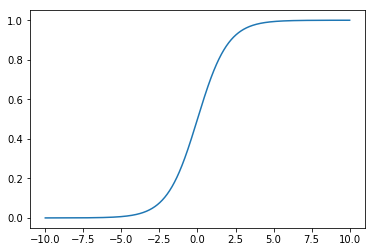

In [89]:
t = np.linspace(-10, 10, 1000)
sigma = 1 / (1 + np.exp(-t))
plt.plot(t, sigma)

/Users/miMacbookPro/anaconda/envs/introtoml/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


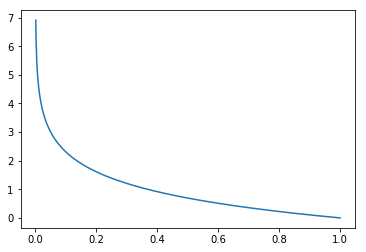

In [177]:
t = np.linspace(0, 1, 1000)
sigma = -np.log(t)
plt.plot(t, sigma)

Before I glossed over the fact that we were using the MSE as a cost function for optimising the linear regressor, on the assumption that you would be familiar with it. This time we will use a cost function that is probably new to you, the logistic regression cost function or log loss for binary classification:

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^m\left[y^{(i)}\log(\hat{p}^{(i)})+ (1-y^{(i)})\log(1-\hat{p}^{(i)})\right]$$

where $y^{(i)}$ can take either a positive or negative value, i.e. $y^{(i)} \in \{0,1\}$.

Unfortunately, unlike the MSE cost function which has a closed form solution (the Normal Equation) so we are forced to find the optimum parameter values through optimisation.

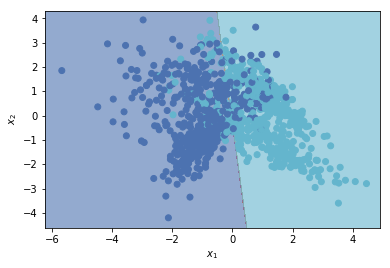

In [54]:
X, y = datasets.make_classification(n_samples=1000, n_features=2, n_redundant=0)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
log_reg = linear_model.LogisticRegression(multi_class="ovr",
                                          solver="lbfgs",
                                          C=10,
                                         )
log_reg.fit(X_train,
            y_train)
log_reg.score(X_test,
              y_test
             )
visualise_decision_surface(X,y,log_reg)

**Do a binary example**

You can handle multi-class problems by extending the above to use the cross entropy loss

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^K y_k^{(i)}\log(\hat{p}_k^{(i)})$$

where

$$\hat{p}_k = \sigma(s({\bf x}))_k = \frac{\exp(s_k({\bf x}))}{\sum_{j=1}^K \exp(s_j({\bf x}))}$$

and

$$s_k({\bf x}) = \theta_k^T \cdot {\bf x}$$

In [55]:
iris = datasets.load_iris()
X = iris["data"]
y = iris["target"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [58]:
print(iris["target_names"])
print(iris["feature_names"])

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [59]:
log_reg = linear_model.LogisticRegression(multi_class="multinomial",
                                          solver="lbfgs",
                                          C=10,
                                         )
log_reg.fit(X_train,
            y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [60]:
log_reg.score(X_test,
              y_test
             )

1.0

In [61]:
log_reg.predict_proba(X_test[0:1,:])

array([[9.87602786e-01, 1.23972137e-02, 7.00659768e-13]])

## Decision Trees <a id='decision_trees'></a>

Decision trees are fantastics because they offer some intuition into the fitting process. A decision tree essentially specifies threshold values in each unique feature, and makes classifications based on which side of the threshold your features lie.

In [204]:
# Download the dataset and load it into pandas dataframe
mushroom_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
feature_names = ["edibility", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment", "gill-spacing", "gill-size",
                 "gill-color", "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
                 "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", 
                 "ring-type", "spore-print-color", "population", "habitat"]
class_names = ["edible", "poisonous"]
mushroom_df = pd.read_csv(mushroom_url,
                      delimiter=",",
                      header=None,
                      names=feature_names,    # Strings for our column headings
                     )

In [205]:
mushroom_df

,edibility,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


In [206]:
labeler = LabelEncoder()
for column in mushroom_df:
    mushroom_df[column] = labeler.fit_transform(mushroom_df[column])

In [7]:
mushroom_df

,edibility,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
5,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1
6,0,0,2,8,1,0,1,0,0,2,...,2,7,7,0,2,1,4,2,2,3
7,0,0,3,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,3,3
8,1,5,3,8,1,6,1,0,1,7,...,2,7,7,0,2,1,4,2,4,1
9,0,0,2,9,1,0,1,0,0,2,...,2,7,7,0,2,1,4,2,3,3


In [207]:
# Test / train split
train_df, test_df = model_selection.train_test_split(mushroom_df)

X_train = train_df.iloc[:,1:].as_matrix()
y_train = train_df.iloc[:,0].as_matrix()

X_test = test_df.iloc[:,1:].as_matrix()
y_test = test_df.iloc[:,0].as_matrix()

/Users/miMacbookPro/anaconda/envs/introtoml/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/Users/miMacbookPro/anaconda/envs/introtoml/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/miMacbookPro/anaconda/envs/introtoml/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/Users/miMacbookPro/anaconda/envs/introtoml/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [208]:
tree_clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)
tree_clf.fit(X_train,
             y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [209]:
tree_clf.score(X_test,
               y_test)

0.9724273756770064

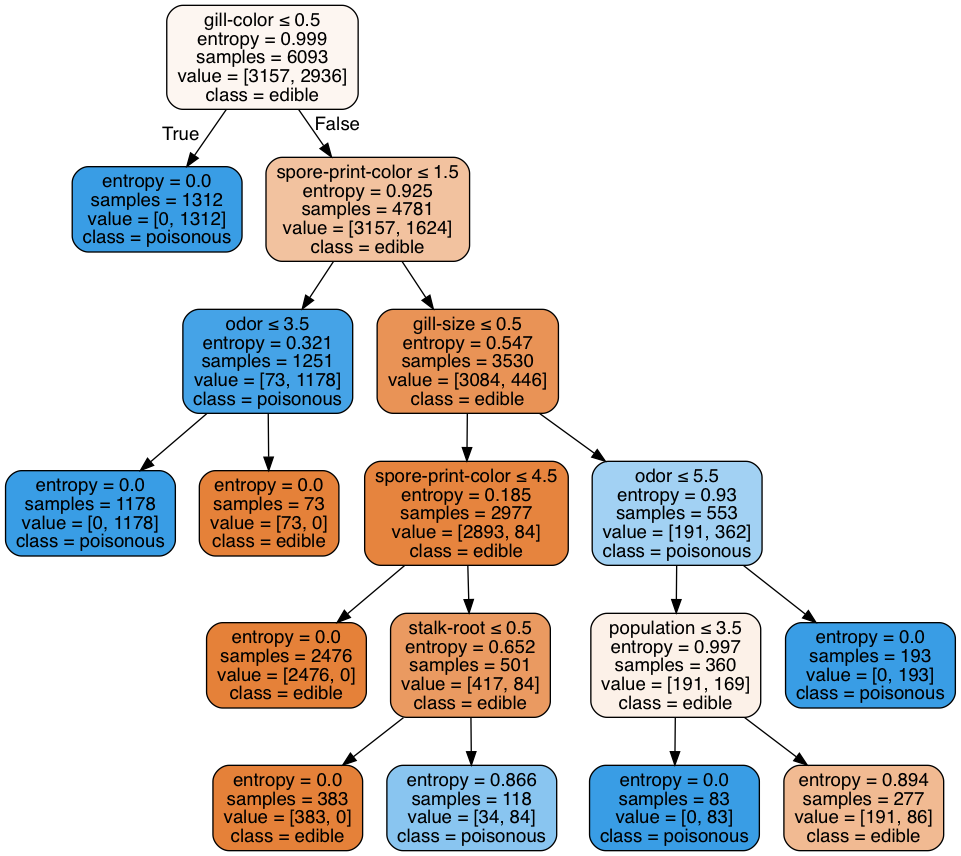

In [210]:
import pydotplus
from IPython.display import Image  
dot_data = tree.export_graphviz(tree_clf, out_file=None, 
                         feature_names=feature_names[1:],  
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

## Suport Vector Machines <a id='svm'></a>

<div class="row">
    <div class="column" style="float:left">
        <img src="https://image.slidesharecdn.com/eventclassificationpredictionusingsupportvectormachine-160405104743/95/event-classification-prediction-using-support-vector-machine-13-638.jpg?cb=1459853447" alt="drawing" width="450px"/>
    </div>
    <div class="column" style="float:left">
    <img src="https://image.slidesharecdn.com/eventclassificationpredictionusingsupportvectormachine-160405104743/95/event-classification-prediction-using-support-vector-machine-15-638.jpg?cb=1459853447" alt="drawing" width="450px"/>
    </div>
</div>
    

A linear SVM classifier is defined by the decision function

$${\bf w}^T\cdot {\bf x} + b = w_1x_1 + w_2x_2 + \cdots + w_nx_n + b$$

If the result of the decision function is positive the predicted class $\hat{y}$ is the positive class (1), otherwise it is the negative class (0)

$$\hat{y} = \begin{cases}
                    0 &\quad \textrm{if} \quad {\bf w}^T \cdot {\bf x} +x < 0,\\
                    1 &\quad \textrm{if} \quad {\bf w}^T \cdot {\bf x} +x \ge 0
            \end{cases} $$
            
The objective function for a linear SVM is

$$ \min_{{\bf w}, b} \frac{1}{2}{\bf w}^T \cdot {\bf w} $$

under the constraint

$$t^{(i)}\left({\bf w}^T \cdot {\bf x}^{(i)} + b\right) \ge 1 \quad \textrm{for } i = 1,2, \dots, m$$

where 

$$t^{(i)} = \begin{cases}
                    -1 &\quad \textrm{if} \quad y^{(i)}=0,\\
                    1 &\quad \textrm{if} \quad y^{(i)}=1
            \end{cases}
$$

You can train an SVM using SGD with an objective function equal to

$$ J({\bf w}, b) = \frac{1}{2}{\bf w}^T\cdot{\bf w} + C\sum_{i=1}^m \max\left(0, 1-t^{(i)}\left({\bf w}^T \cdot {\bf x}^{(i)} + b\right)\right)$$

In [4]:
from sklearn import pipeline,  svm
from sklearn.preprocessing import StandardScaler

In [5]:
iris = datasets.load_iris()
X = iris["data"][:,(2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

svm_clf = pipeline.Pipeline((
                             ("scaler", StandardScaler()),
                             ("linear_svc", svm.LinearSVC(C=1, loss="hinge")),
                           ))
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test)

0.8947368421052632

In [ ]:
visualise_decision_surface(X, y, svm_clf)

In [11]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

In [12]:
X, y = make_moons(n_samples=1000, noise=0.25)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [18]:
polynomial_svm_clf = pipeline.Pipeline((
                                        ("poly_features", PolynomialFeatures(degree=3)),
                                        ("scaler", StandardScaler()),
                                        ("smv_clf", svm.LinearSVC(C=10, loss="hinge"))
                                      ))
polynomial_svm_clf.fit(X_train,
                       y_train)
polynomial_svm_clf.score(X_test,
                       y_test)

0.972

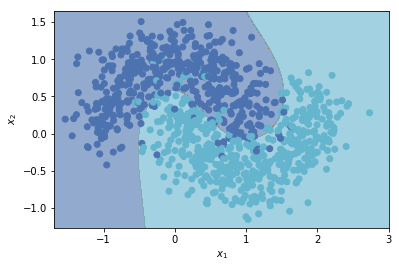

In [19]:
visualise_decision_surface(X, y, polynomial_svm_clf)

In [20]:
poly_kernel_svm_clf = pipeline.Pipeline((
                                         ("scaler", StandardScaler()),
                                         ("svm_clf", svm.SVC(kernel="poly", degree=3, coef0=1, C=5))))
poly_kernel_svm_clf.fit(X_train,
                        y_train)
poly_kernel_svm_clf.score(X_test,
                        y_test)

0.972

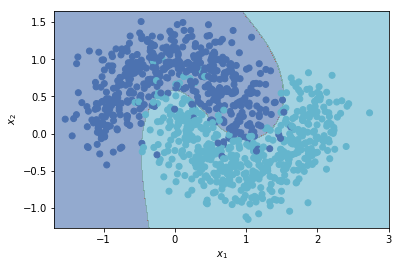

In [21]:
visualise_decision_surface(X, y, poly_kernel_svm_clf)

In [20]:
rbf_kernel_svm_clf = pipeline.Pipeline((("scaler", StandardScaler()),
                                        ("svm_clf", svm.SVC(kernel="rbf", gamma=1, C=1))
                                      ))
rbf_kernel_svm_clf.fit(X_train,
                       y_train)
rbf_kernel_svm_clf.score(X_test,
                         y_test)

0.96

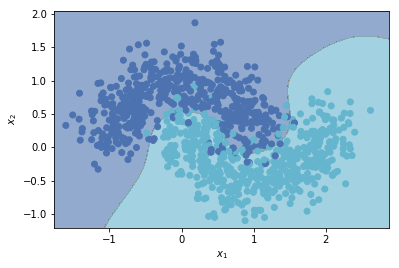

In [21]:
visualise_decision_surface(X, y, rbf_kernel_svm_clf)